In [1]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# load data + generate colors
seed = np.random.seed()
df = pd.read_csv('/Users/SnehPandya/Desktop/DeepLearningAGN/data/clean_full_data_absma2g.csv')
df = df.drop(columns = ['RA', 'DEC', 'ID', 'ERR', 'M_g','M_r','M_z', 'M_u', 'Unnamed: 0','mu'])
df['ug'] = df.apply(lambda row: row.u_band - row.g_band,axis=1)
df['gr'] = df.apply(lambda row: row.g_band - row.r_band,axis=1)
df['ri'] = df.apply(lambda row: row.r_band - row.i_band,axis=1)
df['iz'] = df.apply(lambda row: row.i_band - row.z_band,axis=1)
df['zu'] = df.apply(lambda row: row.z_band - row.u_band,axis=1)
df.head()

,Mass_ground_truth,u_band,g_band,r_band,i_band,z_band,z,M_i,ug,gr,ri,iz,zu
0,8.973414,18.982250,18.900643,18.596375,18.584750,18.720857,1.1875,-25.451,0.081607,0.304268,0.011625,-0.136107,-0.261393
1,8.445230,20.822754,20.706984,20.583098,20.400262,20.097541,2.0993,-25.290,0.115770,0.123885,0.182836,0.302721,-0.725213
2,8.844659,21.185649,20.891439,20.409386,20.336351,20.082965,1.1103,-23.982,0.294211,0.482053,0.073035,0.253386,-1.102684
3,8.051990,20.238111,19.877519,19.916019,19.845519,19.731352,0.6794,-23.246,0.360593,-0.038500,0.070500,0.114167,-0.506759
4,9.409361,17.895957,17.664872,17.407213,17.446128,17.437894,1.0459,-26.482,0.231085,0.257660,-0.038915,0.008234,-0.458064


In [3]:
# define feature and target numpy arrays, do train and test split
X = df.iloc[:, 6:].values
y = df.iloc[:,0].values
X = X.astype(np.float32)
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = seed)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

In [4]:
# define train and test dataset, consolidate tensors
train_ds = TensorDataset(X_train_t,y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

In [5]:
# define train data loader -- does dtype conversion
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x.float()))
        x = F.relu(self.fc2(x.float()))
        x = F.relu(self.fc3(x.float()))
        x = F.relu(self.fc4(x.float()))
        x = F.relu(self.fc5(x.float()))
        x = F.relu(self.fc6(x.float()))
        x = F.relu(self.fc7(x.float()))
        x = self.fc8(x.float())
        return x

net = Net()

In [31]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = F.mse_loss

In [32]:
def fit(num_epochs, model, loss_fn, optimizer):
    for epoch in range(num_epochs): # full passes over the data
        for data in train_dl:  # `data` is a batch of data
            X, y = data  # X is the batch of features, y is the batch of targets.
            net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
            output = net(X.float())  # pass in the reshaped batch (recall they are 28x28 atm)
            loss = loss_fn(output, y.float()) # calc and grab the loss value
            loss.backward()  # apply this loss backwards thru the network's parameters
            optimizer.step()  # attempt to optimize weights to account for loss/gradients
        print(loss)

In [37]:
fit(10, net, loss_function, optimizer)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys


tensor(0.1222, grad_fn=<MseLossBackward>)
tensor(0.7699, grad_fn=<MseLossBackward>)
tensor(0.4738, grad_fn=<MseLossBackward>)
tensor(0.5314, grad_fn=<MseLossBackward>)
tensor(0.1893, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
tensor(0.7053, grad_fn=<MseLossBackward>)
tensor(0.6568, grad_fn=<MseLossBackward>)
tensor(0.0236, grad_fn=<MseLossBackward>)
tensor(0.1373, grad_fn=<MseLossBackward>)


In [39]:
preds2 = net(test_ds[:][0].float())

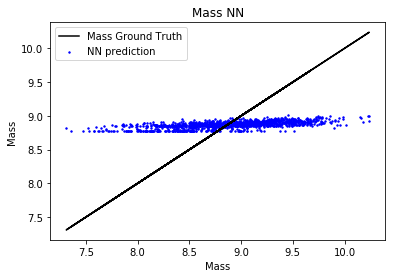

In [40]:
plt.plot(test_ds[:][1],test_ds[:][1],color='black', label = 'Mass Ground Truth')
plt.scatter(test_ds[:][1],preds2.detach().numpy(),s=2,color='blue', label = 'NN prediction')
plt.xlabel('Mass')
plt.ylabel('Mass')
plt.legend()
plt.title ('Mass NN')

In [41]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_t, preds2.detach().numpy())))
print('r2 score:', metrics.r2_score(y_test_t, preds2.detach().numpy()))

Root Mean Squared Error: 0.44953872322719945
r2 score: 0.1122470803656852
